In [109]:
import importlib
import model.Portfolio as Portfolio

# importlib.reload(Portfolio)

<IPython.core.display.Javascript object>

In [92]:
names = ["VUSA", "A35", "S59", "VUSD", "BAB", "IWDA", "Z74", "ES3", "VWRD"]
p = Portfolio.Portfolio()

# Add all assets
for name in names:
    p.addAsset(f"data/{name}.csv", name)

# Convert non SGD assets to SGD
p.addExchangeRate("data/forex/SGDEUR.csv", "EUR", True)
p.addExchangeRate("data/forex/USDSGD.csv", "USD", False)
p.exchangeAdjustment(0, "EUR")
p.exchangeAdjustment(3, "USD")
p.exchangeAdjustment(4, "USD")
p.exchangeAdjustment(5, "USD")
p.exchangeAdjustment(8, "USD")

<IPython.core.display.Javascript object>

In [108]:
currentWeight = [
    0.08992020522,
    0.2744348384,
    0.03070927321,
    0.01896821775,
    0.06166520726,
    0.06204753154,
    0.02053451402,
    0.3393806347,
    0.102339578,
]

p.portfolioPerformance(currentWeight)

{'returns': 0.046602380697228225,
 'variance': 0.004724437320510276,
 'sharpe': 9.864112387503281}

<IPython.core.display.Javascript object>

In [95]:
def randomWeight(length):
    w = np.random.random(length)
    w /= np.sum(w)p.portfolioPerformance(currentWeight)

    return w

<IPython.core.display.Javascript object>

In [105]:
%%time

noSimulations = 100000
rf = 0.02
simWeights = []
simRets = []
simVols = []
simSharpes = []

for i in range(noSimulations):
    weights = randomWeight(len(names))
    perf = p.portfolioPerformance(weights, rf=rf)

    simWeights.append(weights)
    simRets.append(perf["returns"])
    simVols.append(perf["variance"])
    simSharpes.append(perf["sharpe"])

CPU times: user 7min 15s, sys: 197 ms, total: 7min 15s
Wall time: 7min 15s


<IPython.core.display.Javascript object>

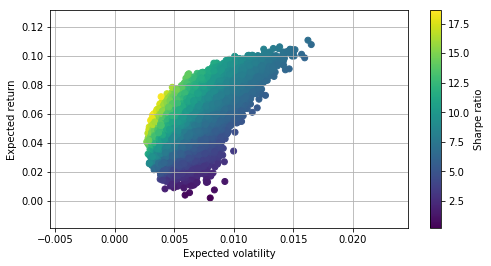

<IPython.core.display.Javascript object>

In [106]:
plt.figure(figsize=(8, 4))
plt.scatter(simVols, simRets, c=simSharpes, marker="o")
plt.grid(True)
plt.xlabel("Expected volatility")
plt.ylabel("Expected return")
plt.colorbar(label="Sharpe ratio")
plt.show()

In [107]:
# Get top 10 portfolio with highest sharpe
sortedIndices = np.argsort(simSharpes)[-10:]

results = []def randomWeight(length):
    w = np.random.random(length)
    w /= np.sum(w)p.portfolioPerformance(currentWeight)

    return w
for x in sortedIndices:
    results.append(np.insert(simWeights[x], 0, [simSharpes[x], simRets[x], simVols[x]]))
pd.DataFrame(results, columns=["SharpeRatio", "Returns", "Volatility"] + stockNames)

,SharpeRatio,Returns,Volatility,VUSA,A35,S59,VUSD,BAB,IWDA,Z74,ES3,VWRD
0,17.586363,0.060570,0.003444,0.072418,0.212689,0.012151,0.132682,0.302197,0.022230,0.115713,0.098291,0.031629
1,17.591324,0.066653,0.003789,0.179694,0.188763,0.053561,0.068376,0.344061,0.094722,0.020814,0.026631,0.023380
2,17.719271,0.058088,0.003278,0.226748,0.179189,0.078401,0.031932,0.345407,0.024440,0.021636,0.062442,0.029806
3,17.763091,0.062938,0.003543,0.133969,0.136979,0.016631,0.042968,0.335027,0.074833,0.095176,0.132276,0.032141
4,17.910012,0.056668,0.003164,0.036104,0.271452,0.042106,0.128020,0.302118,0.073971,0.061930,0.078028,0.006271
5,18.128444,0.055145,0.003042,0.102863,0.251718,0.031181,0.020645,0.335275,0.018312,0.096944,0.027709,0.115353
6,18.235494,0.060104,0.003296,0.084218,0.265312,0.000736,0.086479,0.271639,0.088419,0.069527,0.132408,0.001260
7,18.372736,0.055728,0.003033,0.143624,0.261077,0.006435,0.005382,0.281305,0.069550,0.081220,0.128430,0.022976
8,18.421896,0.071838,0.003900,0.087384,0.156163,0.003288,0.110083,0.370604,0.117376,0.037562,0.101586,0.015954
9,18.612759,0.058980,0.003169,0.175805,0.209894,0.022914,0.040349,0.305930,0.030847,0.036826,0.148211,0.029224


<IPython.core.display.Javascript object>

## Next Step

- Timeseries K-fold validation when generating weights
    - Monte carlo on K-1 segments of data
    - Test result on 1 segment of data
- Genetics algorithm
- Add backtest capabilities
    - Report over the entire period
    - Custom period

## Even More Advanced Shits

- Selective optimisation for time period (ie interest rate hike, financial crisis, etc)